<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_JB_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-image
#--quiet
!pip install matplotlib
#--quiet
!pip install pandas
#--quiet
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install cellpose

In [3]:
import matplotlib
import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
from tqdm import tqdm
import scipy as sci
from cellpose import models

In [4]:
def plot_point_data_pcol(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None,cmap='viridis'):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x]
        x=rad
        y=rad

    xy_slice = image_stack[z,:,:]
    zy_slice = image_stack[:,:,x].transpose([1,0])
    zx_slice = image_stack[:,y,:]

    vmin = np.percentile(image_stack,.1)
    vmax = np.percentile(image_stack,99.9)
    print(vmin,vmax)

    fig,ax=plt.subplots(2,3,width_ratios=[5, 1, .5],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax=ax.flatten()
    # ,aspect='auto'
    cbh=ax[0].pcolorfast(xy_slice,zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])
    ax[0].invert_yaxis()

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[3].imshow(zx_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[3].axvline(x,color='m',linewidth=lw)
    ax[3].axhline(z,color='y',linewidth=lw)

    plt.colorbar(cbh,cax=ax[2])

    for a in ax[4:]:
        a.axis('off')
    plt.tight_layout()
    return fig,ax,cbh

In [5]:
def plot_point_data_rgb(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    print(image_stack.shape,x,y)

    xy_slice = image_stack[z,:,:,:]
    zy_slice = image_stack[:,:,x,:].transpose([1,0,2])
    zx_slice = image_stack[:,y,:,:]


    z_ratio = image_stack.shape[0]/image_stack.shape[1]

    fig,ax=plt.subplots(2,2,width_ratios=[1, z_ratio],height_ratios=(1,z_ratio),figsize=figsize,dpi=300)
    ax=ax.flatten()

    ax[0].imshow(xy_slice,aspect='auto',zorder=-1) # vmin=vmin,vmax=vmax,cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[2].imshow(zx_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[2].axvline(x,color='m',linewidth=lw)
    ax[2].axhline(z,color='y',linewidth=lw)




    ax[3].axis('off')
    plt.tight_layout()
    return fig,ax



def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format,clip=False):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

def med_filt_stack(img,d):
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = ski.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img


In [9]:

"""On Site"""
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/'
"""Off Site"""
source_directory = 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF'


os.chdir(source_directory)


In [10]:

my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
print(my_tiffs)

curr_tif = my_tiffs[0]

['C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-E_20x2_1.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-E_20x2_2.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-F_20x2_1.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-F_20x2_2.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-G_20x2_1.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-G_20x2_2.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-H_20x2_1.tif', 'C:\\Users\\denni\\Dropbox

In [11]:
tiff_format = 'zcyx'
color_format = 'RB'
rbg_channel_order = [1,0,0]

In [12]:
tiff_data_raw = tifffile.imread(curr_tif)
tiff_data = tiff_data_raw.copy()
tiff_format = 'zcyx'
print(tiff_data.shape)

tiff_data = ski.filters.gaussian(tiff_data, sigma=[1,1,1],mode='reflect',truncate = 4,channel_axis=1)
tiff_data = med_filt_stack(tiff_data,5)
print(tiff_data.shape)
tiff_data = norm_channels(tiff_data,'zcyx',clip=True)
tiff_data = tiff_data[:,rbg_channel_order,:,:]
print(tiff_data.shape)
tiff_data[:,1,:,:]=0


(29, 2, 800, 800)
(29, 2, 800, 800)
(29, 3, 800, 800)


In [ ]:
rgb_stack = tiff_data.transpose(0,2,3,1)*225
rgb_stack[rgb_stack<0]=0
rgb_stack[rgb_stack>255]=255
rgb_stack=rgb_stack.astype('uint8')

# _=plot_point_data_rgb(400,600,20,rgb_stack,figsize=(3,2.7)) #,rad=50


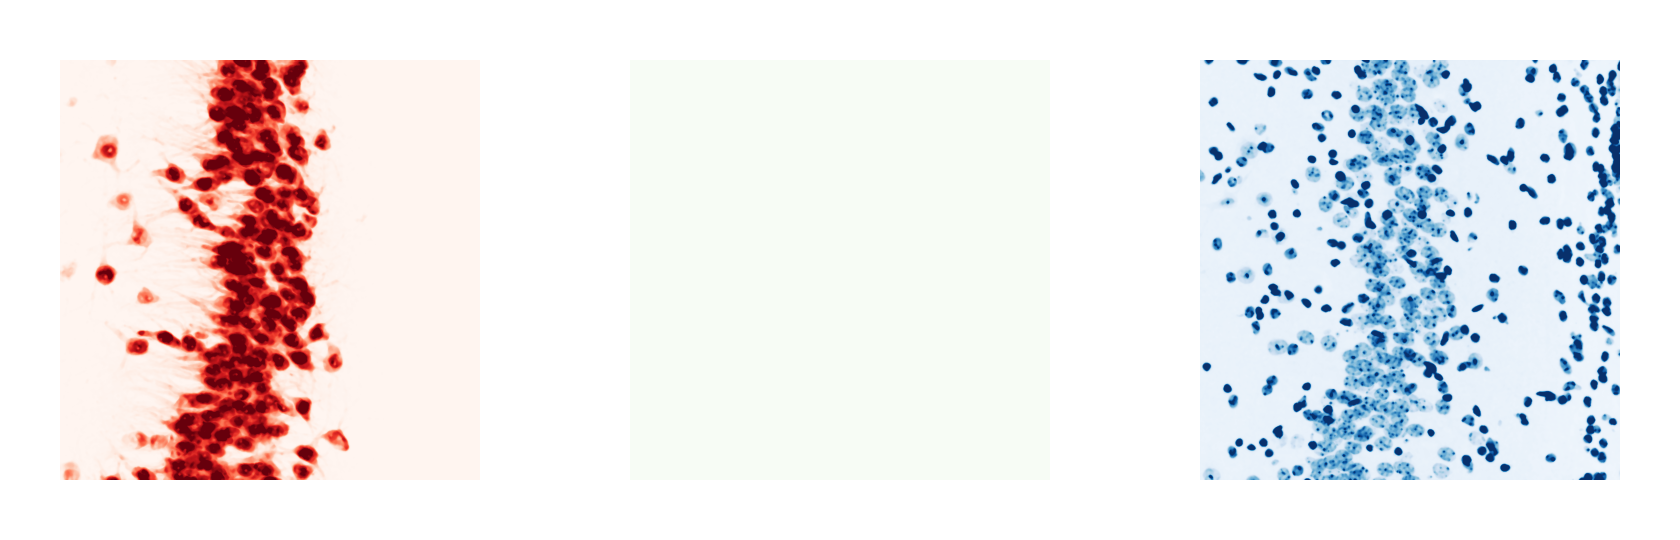

In [14]:
""" Display Split Projections """
num_c = tiff_data.shape[1]
fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=600)
colors = ['Reds','Greens','Blues','gray']
for c in range(num_c):
    ax[c].imshow(np.max(tiff_data[:,c,:,:],axis=0), cmap=colors[c],vmin=0,vmax=1)
    ax[c].axis('off')
plt.tight_layout()

In [15]:
# colors = ['Reds','Greens','Blues','gray_r']
# for z in range(tiff_data.shape[0]):
#     num_c = tiff_data.shape[1]
#     fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
#     for c in range(num_c):
#         ax[c].imshow(tiff_data[z,c], cmap=colors[c],vmin=0,vmax=1)
#         ax[c].axis('off')
#     plt.tight_layout()
#     plt.show()

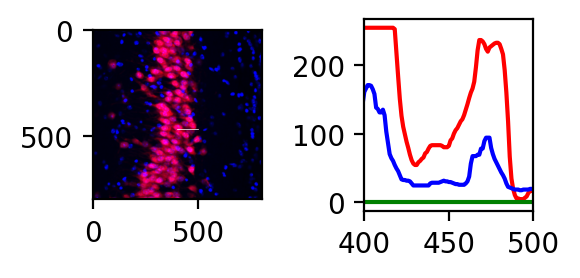

In [17]:
z_show = 13

img_rgb = tiff_data.transpose([0,2,3,1])*255
img_rgb[img_rgb>255]=255
img_rgb[img_rgb<0]=0
img_rgb=img_rgb.astype('uint8')
fig,ax =plt.subplots(1,2,figsize=(3,1.5),dpi=200)
ax[0].imshow(img_rgb[z_show])
y=465
xb=np.cumsum([400,100])
ax[0].plot(xb,[y,y],'w',linewidth=.25)
ax[1].plot(img_rgb[z_show,y,:,0],color='r')
ax[1].plot(img_rgb[z_show,y,:,1],color='g')
ax[1].plot(img_rgb[z_show,y,:,2],color='b')
ax[1].set_xlim(xb)
plt.tight_layout()

In [18]:
zi = 35
cell_diam = 30
nuc_diam = None
cell_channel = 0
nuclear_channel = 3
channel_axis = 3

image is not 2D cannot compute diameter
C:\Users\denni\anaconda3\envs\Soma\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 146.60it/s]


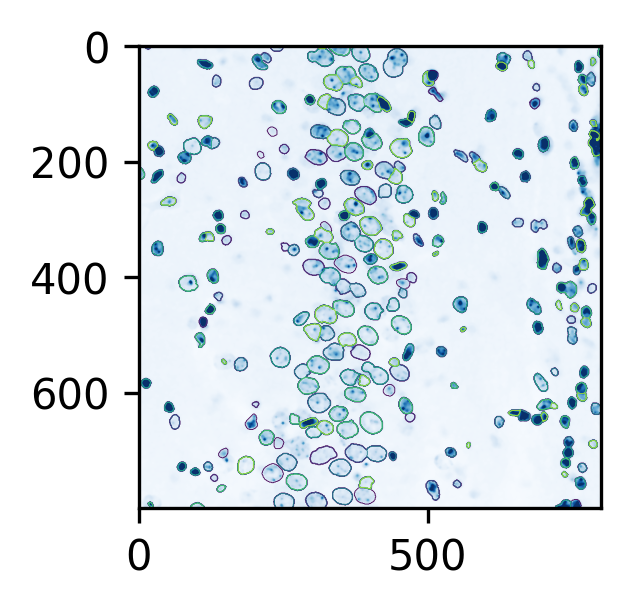

In [36]:
""" Define Nuclear Model """
nuclear_model = models.Cellpose(model_type='nuclei',gpu=True)
(nuclear_masks, _, _, _) =  nuclear_model.eval(img_rgb, channels=[nuclear_channel, 0], channel_axis = channel_axis, diameter=nuc_diam, do_3D=False, stitch_threshold=0.02,) # ,stitch_threshold=0.02

fig,ax=plt.subplots(1,figsize=(2,2),dpi=300)
plt.imshow(img_rgb[20,:,:,2],cmap='Blues')
plt.contour(nuclear_masks[20,:,:],linewidths=.2)


In [57]:
""" Define Cell Model """
cell_diam=40
cell_model = models.Cellpose(model_type='cyto3',gpu=True)
cell_channel = 1
nuclear_channel = 0
print('nuclear_channel',nuclear_channel)
print('cell_channel',cell_channel)
(cell_masks, flows, styles, diams) =  cell_model.eval(img_rgb, channels=[cell_channel,nuclear_channel], channel_axis = channel_axis, diameter=cell_diam, do_3D=False, stitch_threshold=0.02,) # ,stitch_threshold=0.02, diameter=diam,
fig,ax=plt.subplots(1,figsize=(3,3),dpi=300)
plt.imshow(np.sum(cell_masks>0,axis=0))

nuclear_channel 0
cell_channel 1


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 172.84it/s]


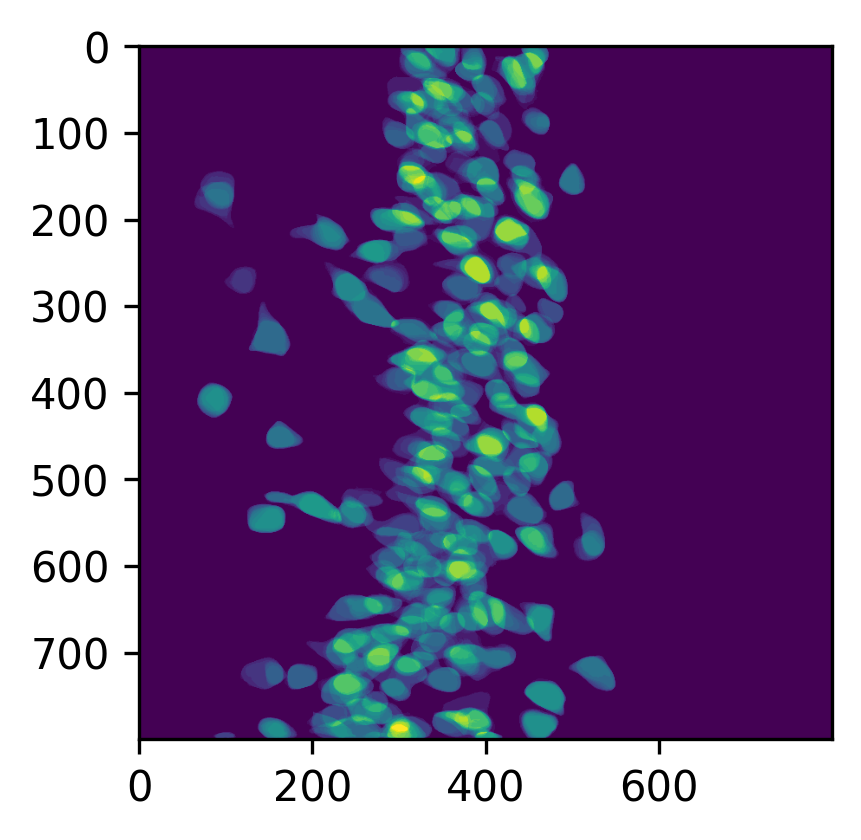

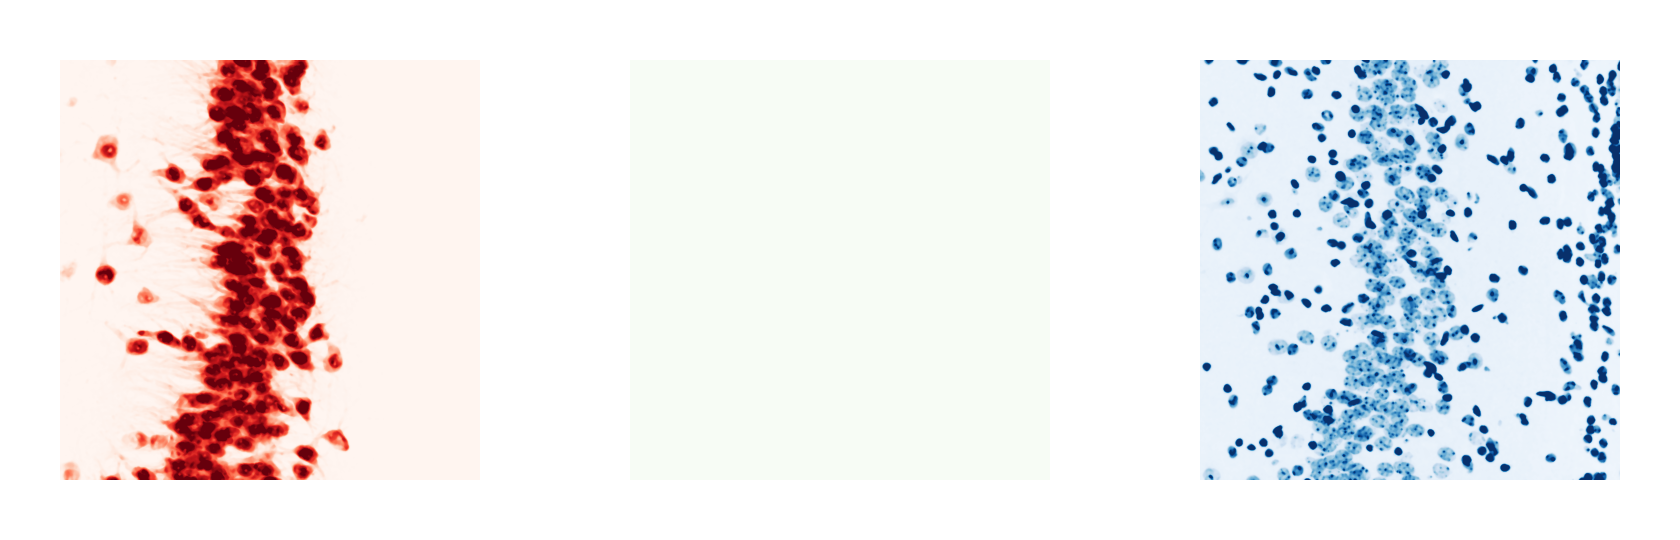

In [59]:
""" Display Split Projections """
num_c = tiff_data.shape[1]
fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=600)
colors = ['Reds','Greens','Blues','gray']
for c in range(num_c):
    ax[c].imshow(np.max(tiff_data[:,c,:,:],axis=0), cmap=colors[c],vmin=0,vmax=1)
    ax[c].axis('off')
plt.tight_layout()

In [60]:
def no_edges(masks):
    masks_og = masks.copy()
    planes = [masks[0,:,:],
              masks[-1,:,:],
              masks[:,0,:],
              masks[:,-1,:],
              masks[:,:,0],
              masks[:,:,-1]]

    for p in planes:
        del_ids = np.unique(p)
        for id in del_ids:
            masks[masks==id] = 0
    return masks, masks_og

cell_masks, cell_masks_og = no_edges(cell_masks)

In [61]:
nuc_ids = np.unique(nuclear_masks)
cell_ids = np.unique(cell_masks)
nuc_ids = nuc_ids[nuc_ids>0]
cell_ids = cell_ids[cell_ids>0]
sizes, edges = np.histogram(cell_masks.flatten(),bins=np.concatenate([cell_ids,[np.max(cell_ids+1)]]))
cell_df = pd.DataFrame({'cell_ids':cell_ids,'nuc_ids':[list()]*len(cell_ids),'size_vxl':sizes}).set_index('cell_ids')
for c in cell_df.index:
    nucs = nuclear_masks[cell_masks==c]
    nucs = nucs[nucs>0]
    cell_df.at[c,'nuc_ids']=np.unique(nucs)
multi_nuc=[np.prod(np.shape(ni))>1 for ni in cell_df['nuc_ids']]
cell_df['multi_nuc']=multi_nuc
cell_df = cell_df[~cell_df['multi_nuc']]

no_nucs =[np.prod(np.shape(ni))<1 for ni in cell_df['nuc_ids']]
cell_df['no_nucs']=no_nucs
cell_df = cell_df[~cell_df['no_nucs']]
display(cell_df.head(500))

,nuc_ids,size_vxl,multi_nuc,no_nucs
cell_ids,,,,
6,85,15180,False,False
33,216,3793,False,False
38,154,21667,False,False
42,160,1336,False,False
44,165,2225,False,False
51,167,2745,False,False
64,138,5339,False,False
72,137,1440,False,False
90,97,2870,False,False


In [62]:
filt_mask=np.zeros_like(cell_masks)
for cell in cell_df.index:
    filt_mask[cell_masks==cell]=cell

0.0 21667.0


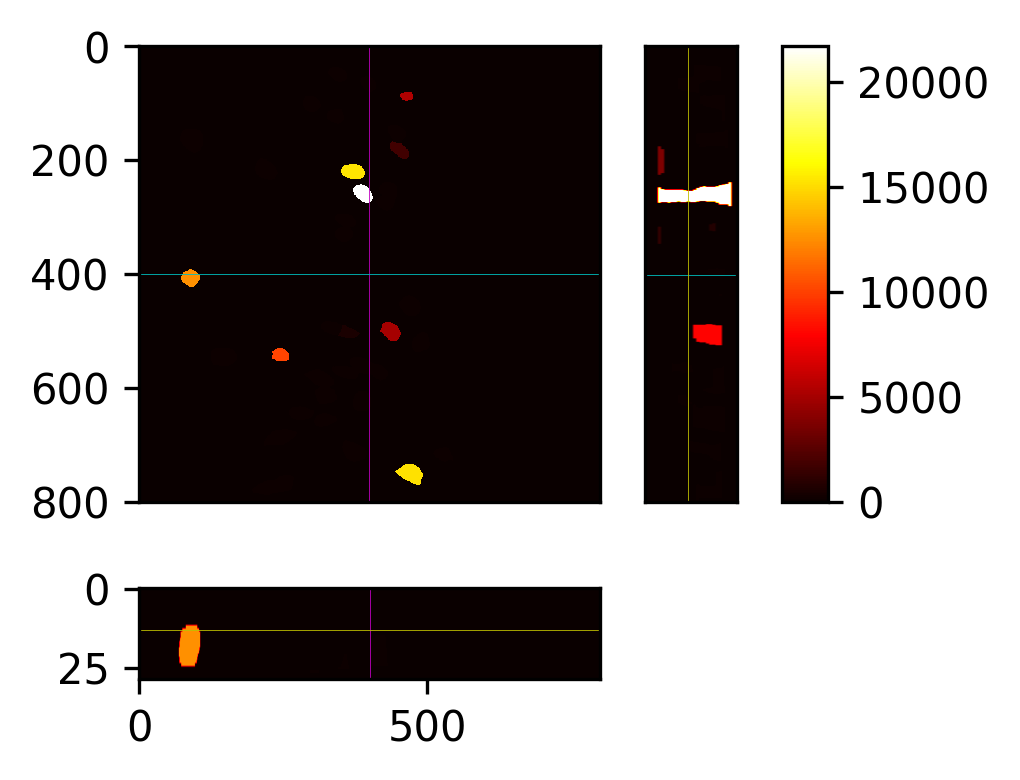

In [63]:
size_mask=cell_masks.copy()
for c in cell_df.index:
    size_mask[filt_mask==c]=cell_df.loc[c,'size_vxl']

fi,ax,cbh = plot_point_data_pcol(400,400,13,size_mask,figsize=(3.5,2.7),cmap='hot')
tifffile.imwrite('./size_mask.tif',size_mask)

(29, 800, 800, 3) 340 420


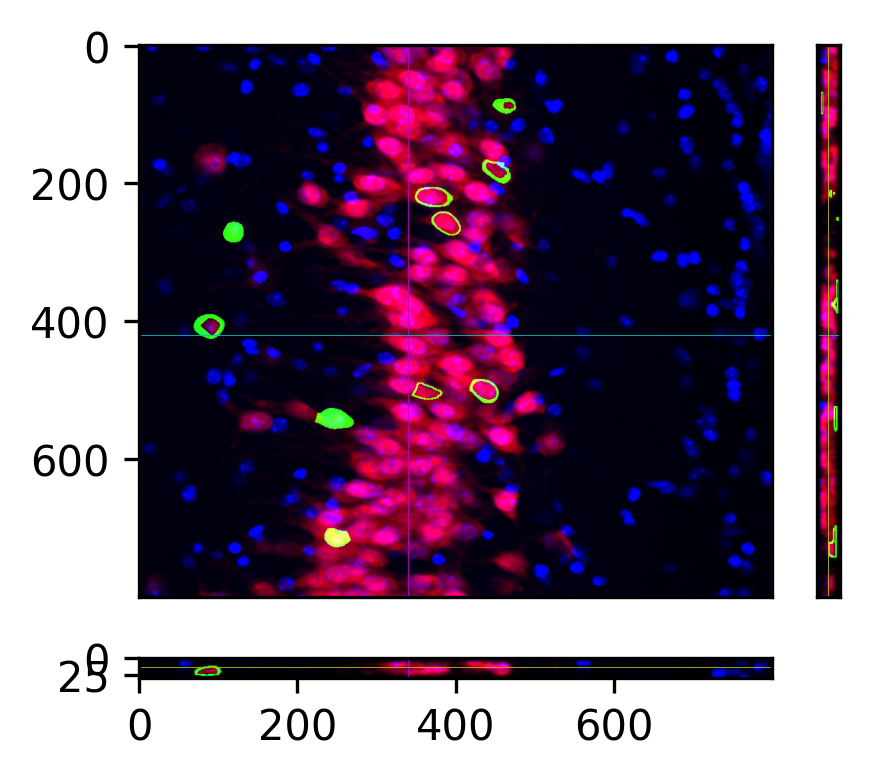

In [66]:
""" Mark Edges """
edges = ski.filters.sobel(filt_mask)
is_border = (edges-np.mean(edges)) > np.std(edges)*.9
rgb_borders = img_rgb.copy()
rgb_borders[:,:,:,1] = is_border*255
plot_point_data_rgb(340,420,13,rgb_borders,figsize=(3,2.7))
tifffile.imwrite('./rgb_borders.tif',rgb_borders)

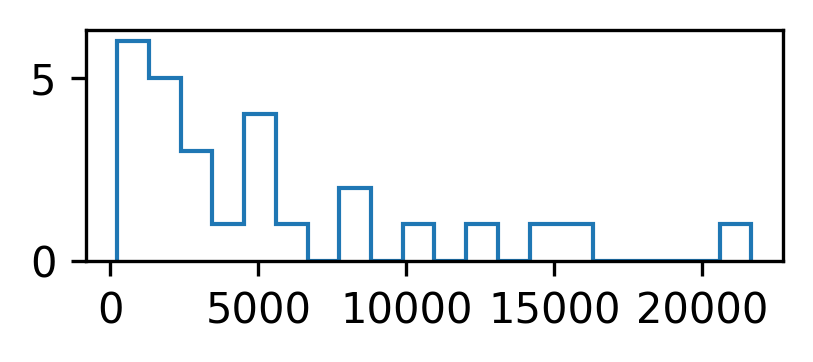

In [67]:
# size_bins = np.logspace(np.log10(np.min(sizes_um)),np.log10(np.max(sizes_um)),num=30,base=10)
counts,size_bins = np.histogram(cell_df['size_vxl'],bins=20)
fig,ax=plt.subplots(1,figsize=(3,1),dpi=300)
ax.stairs(counts,size_bins)
# ax.set_xscale('log')
# kinda_big = 100
# ax.axvline(kinda_big,color='k',ls=':')

0.0 4.0


(<Figure size 900x810 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object),
 <matplotlib.image.AxesImage at 0x279069ba1d0>)

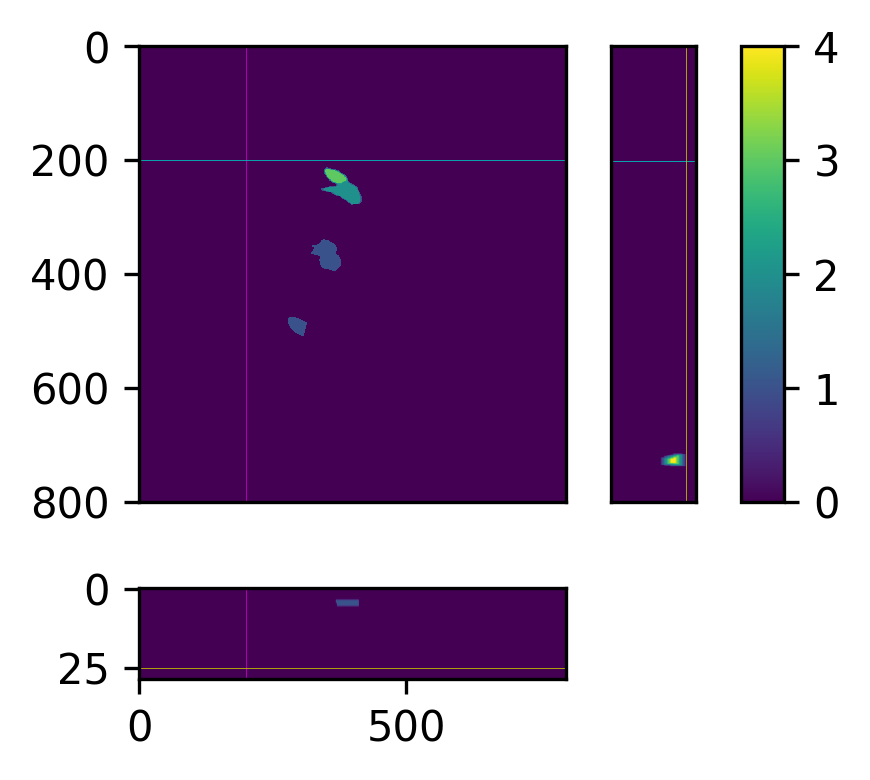

In [68]:

distance = sci.ndimage.distance_transform_edt((filt_mask>0)*1)
plot_point_data_pcol(200,200,25,distance,figsize=(3,2.7))

# labels = ski.segmentation.watershed(distance)
# plot_point_data_pcol(200,200,25,labels,figsize=(3,2.7))

In [69]:
def nd_feret(mask,scalars=None):
    if scalars is None:
        scalars=np.ones_like(mask.shape)
    n_coords=np.where(mask)
    feret_diams = list()
    for s, coord in zip(scalars,n_coords):
        diam = np.max(coord)-np.min(coord)
        feret_diams.append(diam*s)
    return feret_diams


In [70]:
cell_df['max_dist']=np.nan
cell_df['feret_d']=np.nan
cell_df['feret_d']= cell_df['feret_d'].astype(object)
for cell in cell_df.index:
    cell_df.at[cell,'max_dist']=np.max(distance[filt_mask==cell])
    cell_df.at[cell,'feret_d'] = nd_feret(filt_mask==cell) #,scalars=voxel_size_um[[2,0,1]]
display(cell_df.head(500))

,nuc_ids,size_vxl,multi_nuc,no_nucs,max_dist,feret_d
cell_ids,,,,,,
6,85,15180,False,False,7.000000,"[12, 42, 48]"
33,216,3793,False,False,1.000000,"[1, 65, 46]"
38,154,21667,False,False,11.224972,"[22, 44, 78]"
42,160,1336,False,False,1.000000,"[0, 33, 62]"
44,165,2225,False,False,2.000000,"[2, 33, 30]"
51,167,2745,False,False,2.000000,"[3, 25, 48]"
64,138,5339,False,False,5.000000,"[9, 31, 33]"
72,137,1440,False,False,1.000000,"[0, 33, 60]"
90,97,2870,False,False,2.000000,"[3, 31, 37]"


,nuc_ids,size_vxl,multi_nuc,no_nucs,max_dist,feret_d,prod_f,fill
cell_ids,,,,,,,,
6,85,15180,False,False,7.000000,"[12, 42, 48]",24192,0.627480
33,216,3793,False,False,1.000000,"[1, 65, 46]",2990,1.268562
38,154,21667,False,False,11.224972,"[22, 44, 78]",75504,0.286965
42,160,1336,False,False,1.000000,"[0, 33, 62]",0,inf
44,165,2225,False,False,2.000000,"[2, 33, 30]",1980,1.123737
51,167,2745,False,False,2.000000,"[3, 25, 48]",3600,0.762500
64,138,5339,False,False,5.000000,"[9, 31, 33]",9207,0.579885
72,137,1440,False,False,1.000000,"[0, 33, 60]",0,inf
90,97,2870,False,False,2.000000,"[3, 31, 37]",3441,0.834060


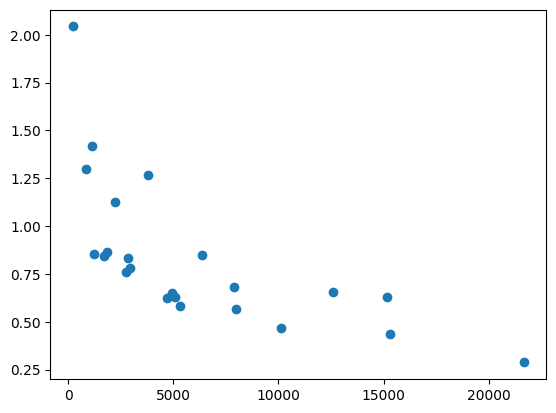

In [72]:
cell_df['prod_f']=[np.prod(fd) for fd in cell_df['feret_d'].values]
cell_df['fill'] = cell_df['size_vxl']/cell_df['prod_f']
display(cell_df.head(300))
plt.scatter(cell_df['size_vxl'],cell_df['fill'])

[10, 23, 33]


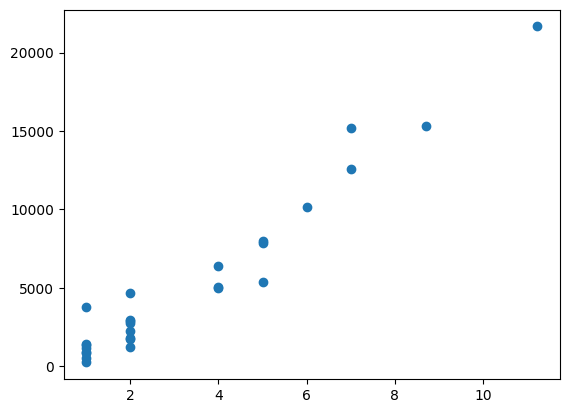

In [73]:
plt.scatter(cell_df['max_dist'],cell_df['size_vxl'])